# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

simulation_file = 'grenoble_2018-10-10_1811799.zip'
dfsim = read_result(simulation_file)
dfsim['mode'] = 'simulation_calibration'
dfsim_old = read_result('grenoble_2018-10-10_1811801.zip')
dfsim_old['mode'] = 'simulation_trace'
dfexec = read_result('../hpl/grenoble_2018-10-02_1810918.zip')
dfexec['mode'] = 'execution_new'
df = pandas.concat([dfsim, dfsim_old, dfexec])
sizes = set(dfsim.matrix_size) & set(dfexec.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,application_time,bcast,block_size,cpu_utilization,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,gflops,...,proc_q,process_per_node,residual,rfact,simulation_time,swap,sys_time,thread_per_process,time,usr_time
0,3.17672,2,128,0.99,1,6.484604e-11,0.00024,8.021068e-11,6.929164e-07,39.89,...,32,32,NaN,2,33.1254,0,2.49,1,1.15,30.62
2,77.39410,2,128,0.90,1,6.484604e-11,0.00024,8.021068e-11,6.929164e-07,12510.00,...,32,32,NaN,2,752.8060,0,51.12,1,120.03,626.79
3,40.33750,2,128,0.99,1,6.484604e-11,0.00024,8.021068e-11,6.929164e-07,7796.00,...,32,32,NaN,2,380.0860,0,27.45,1,24.07,351.18
4,15.99030,2,128,0.99,1,6.484604e-11,0.00024,8.021068e-11,6.929164e-07,1398.00,...,32,32,NaN,2,158.0630,0,11.02,1,7.08,146.62
5,5.73115,2,128,0.99,1,6.484604e-11,0.00024,8.021068e-11,6.929164e-07,158.40,...,32,32,NaN,2,57.9575,0,4.10,1,2.31,53.80


### Checking the parameters

In [2]:
dfsim[['dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept']].drop_duplicates()

,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,6.484604e-11,0.00024,8.021068e-11,6.929164e-07


In [3]:
dfsim_old[['dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept']].drop_duplicates()

,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,6.776502e-11,0.000869,5.449172e-11,0.00005


In [4]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,block_size,proc_p,bcast,proc_q,swap,mem_align,thread_per_process,process_per_node,depth,pfact,rfact
0,128,16,2,32,0,8,1,32,1,1,2


In [5]:
print(zipfile.ZipFile(simulation_file).read('dahu.xml').decode('ascii'))

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.9654918472829634e-07:9.636195922971908e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375224e-06:8.456019002037343e-11;8133:0.0:0.0;15831:0.0:0.0;33956:0.0:0.0;63305:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.93122952108322e-07:7.051204536228499e-11;8133:3.601990790153314e-07:1.2449128895712003e-10;15831:2.977016881030904e-06:4.130261264964205e-11;33956:3.1334661540668004e-06:3.293458765282178e-11;63305:6.939993663604218e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4709912642540426;8133:0.6770561715947873;15831:0.7091971477925826;33956:0.7033449540683548;63305:0.9867951082730284"/>
        <prop id="smpi/lat-factor" value="0:1.1347371681807956;8133:29.84698135078078;15831:30.274775156187765;33956:64.63917831305292;633

### Comparing the simulation with the real execution

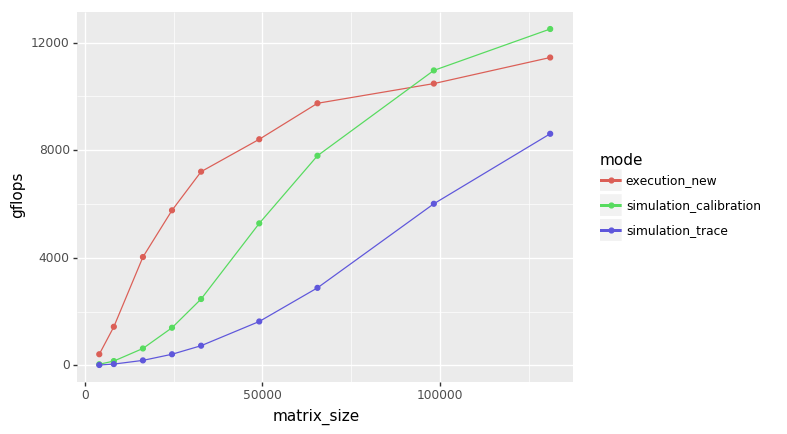

<ggplot: (8758203002425)>

In [6]:
ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + geom_line() + geom_point()

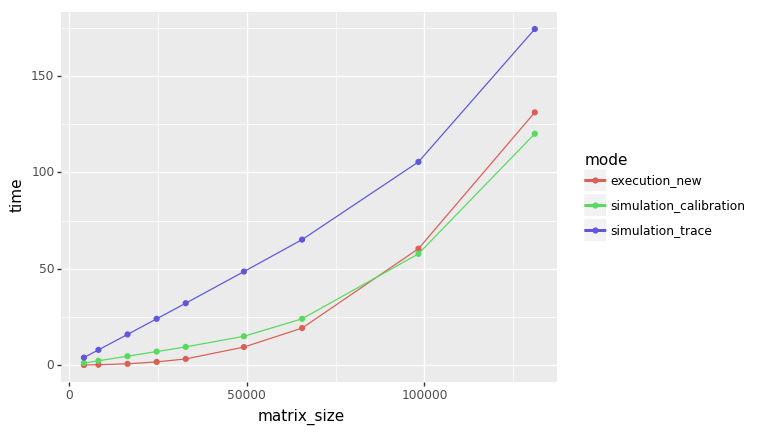

<ggplot: (8758202986027)>

In [7]:
ggplot(df, aes(x='matrix_size', y='time', color='mode')) + geom_line() + geom_point()

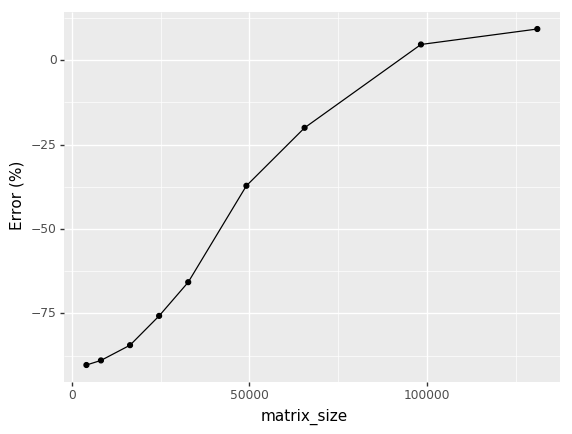

<ggplot: (-9223363278653954318)>

In [8]:
tmp = dfsim.set_index('matrix_size').join(dfexec.set_index('matrix_size'), rsuffix='_real').reset_index()
tmp['error'] = (tmp.gflops - tmp.gflops_real) / tmp.gflops_real * 100
tmp = tmp[~tmp.error.isna()]
ggplot(tmp, aes(x='matrix_size', y='error')) + geom_line() + geom_point() + ylab('Error (%)')

### Efficiency of the simulation

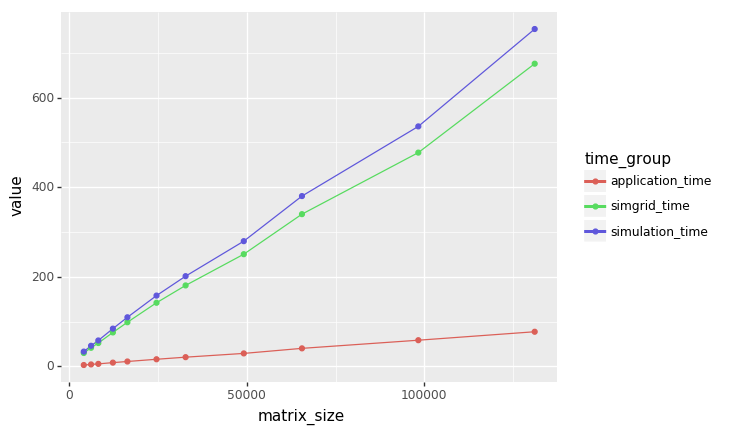

<ggplot: (-9223363278651757915)>


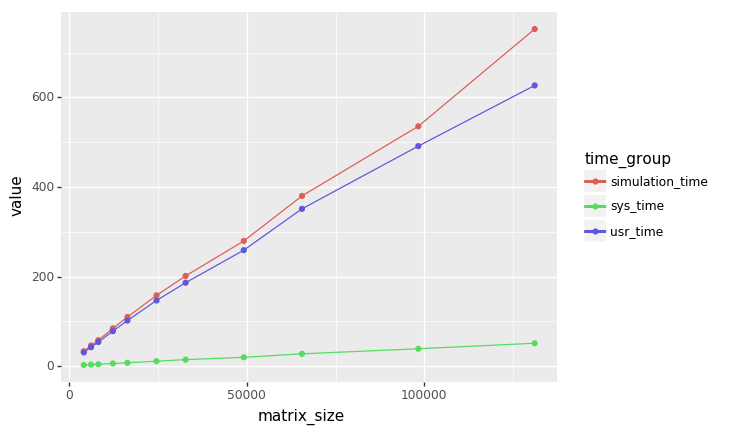

<ggplot: (8758200589583)>

In [9]:
dfsim['simgrid_time'] = dfsim.simulation_time - dfsim.application_time

print(ggplot(dfsim.melt(id_vars=['matrix_size'], value_vars=['simulation_time', 'application_time', 'simgrid_time'], var_name='time_group'),
       aes(x='matrix_size', y='value', color='time_group')) + geom_line() + geom_point())

ggplot(dfsim.melt(id_vars=['matrix_size'], value_vars=['simulation_time', 'usr_time', 'sys_time'], var_name='time_group'),
       aes(x='matrix_size', y='value', color='time_group')) + geom_line() + geom_point()